In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('/data', one_hot=True)

Extracting /data\train-images-idx3-ubyte.gz
Extracting /data\train-labels-idx1-ubyte.gz
Extracting /data\t10k-images-idx3-ubyte.gz
Extracting /data\t10k-labels-idx1-ubyte.gz


In [12]:
def encode(lstm_enc, input, state):
    global REUSE
    with tf.variable_scope("encoder"):
        return lstm_enc(input, state)

def decode(lstm_dec, input, state):
    with tf.variable_scope("decoder"):
        return lstm_dec(input, state)

def read_no_attn(x, x_hat, h_dec_prev):
    return tf.concat([x, x_hat], 1)

def read_attn(x, x_hat, h_dec_prev):
    pass

def write_no_attn(h_dec, img_size):
    with tf.variable_scope('writer'):
        return linear(h_dec, img_size)

def write_attn(h_dec, img_size):
    pass

In [4]:
def linear(X, out_dim):
    W = tf.get_variable("W", [X.get_shape()[1], out_dim])
    b = tf.get_variable("b", [out_dim], initializer=tf.constant_initializer(.0))
    return tf.matmul(X,W)+b

def sampleQ(h_enc, z_size, e):
    with tf.variable_scope('mu'):
        mu = linear(h_enc, z_size)
    with tf.variable_scope('sigma'):
        logstd = linear(h_enc, z_size)
        std = tf.exp(logstd)
    z = mu + std*e
    return z, mu, logstd, std

In [106]:
# input size
A = B = 28
img_size = A*B

# latent dimension
z_size = 100

# sequence length
T = 10

# total time-step
glimpses = 64

enc_size = 256
dec_size = 256

is_read_attn = False
is_write_attn = False

# read and write size
read_size  = 5 if is_read_attn else 2*img_size
write_size = 5

#
batch_size = 100
learning_rate = 1e-3

read  = read_attn  if is_read_attn  else read_no_attn
write = write_attn if is_write_attn else write_no_attn

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, (batch_size, img_size), 'inputs')
    
    noise = tf.random_normal((batch_size, z_size), dtype=tf.float32)

    lstm_enc = LSTMCell(enc_size)
    lstm_dec = LSTMCell(dec_size)
    
    h_dec_prev = tf.zeros((batch_size, dec_size))
    enc_state = lstm_enc.zero_state(batch_size, tf.float32)
    print('enc_state cell:   {}'.format(enc_state[0].get_shape()))
    print('enc_state hidden: {}'.format(enc_state[1].get_shape()))
    dec_state = lstm_dec.zero_state(batch_size, tf.float32)
    print('dec_state cell:   {}'.format(dec_state[0].get_shape()))
    print('dec_state hidden: {}'.format(dec_state[1].get_shape()))

    c = [0]*T
    mus, logstds, stds = [0]*T, [0]*T, [0]*T
    
    with tf.variable_scope('draw') as scope:
        for t in range(T):
            if t > 0:
                scope.reuse_variables()
            cprev = tf.zeros((batch_size, img_size)) if t==0 else c[t-1]
            cprev = tf.zeros((batch_size, img_size))
            # x_hat is the error image
            x_hat = x - tf.sigmoid(cprev)
            # read operation
            #   without attention shape [batch_size, 1568] (784*2 the img_size)
            r = read(x, x_hat, h_dec_prev)
            #
            h_enc, enc_state = encode(lstm_enc, tf.concat([r, h_dec_prev],1), enc_state)

            z, mus[t], logstds[t], stds[t] = sampleQ(h_enc, z_size, noise)
            #
            h_dec, dec_state = decode(lstm_dec, z, dec_state)
            c[t] = cprev + write(h_dec, img_size)
            h_dec_prev = h_dec
    
    print('\n--- TRAINABLE VARIABLES ---')
    for var in tf.trainable_variables():
        print(var)

enc_state cell:   (100, 256)
enc_state hidden: (100, 256)
dec_state cell:   (100, 256)
dec_state hidden: (100, 256)

--- TRAINABLE VARIABLES ---
<tf.Variable 'draw/encoder/lstm_cell/kernel:0' shape=(2080, 1024) dtype=float32_ref>
<tf.Variable 'draw/encoder/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'draw/mu/W:0' shape=(256, 100) dtype=float32_ref>
<tf.Variable 'draw/mu/b:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'draw/sigma/W:0' shape=(256, 100) dtype=float32_ref>
<tf.Variable 'draw/sigma/b:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'draw/decoder/lstm_cell/kernel:0' shape=(356, 1024) dtype=float32_ref>
<tf.Variable 'draw/decoder/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'draw/writer/W:0' shape=(256, 784) dtype=float32_ref>
<tf.Variable 'draw/writer/b:0' shape=(784,) dtype=float32_ref>


In [107]:
# LOSS FUNCTION
def binary_crossentropy(y, y_hat, eps=1e-8):
    return -(y*tf.log(y_hat+eps) + (1.-y)*(tf.log(1.-y_hat+eps)))
    
with graph.as_default():
    x_recons = tf.nn.sigmoid(c[-1])
    Lx = tf.reduce_sum(binary_crossentropy(x, x_recons), 1)
    Lx = tf.reduce_mean(Lx)
    
    kl_terms = [0]*T
    for t in range(T):
        mu2 = tf.square(mus[t])
        std2 = tf.square(stds[t])
        logstd = logstds[t]
        
        kl_terms[t] = .5 * tf.reduce_sum(mu2 + std2 - 2*logstd,1) - .5
    KL = tf.add_n(kl_terms)
    Lz = tf.reduce_mean(KL)
    
    cost = Lx + Lz

# OPTIMIZER
with graph.as_default():
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=.5)
    
    grads = opt.compute_gradients(cost)
    for i, (g,v) in enumerate(grads):
        if g is not None:
            grads[i] = (tf.clip_by_norm(g,5), v)
    train_op = opt.apply_gradients(grads)


In [146]:
from datetime import datetime

In [155]:
datetime.now()

datetime.timedelta(0)

In [145]:
time()

1515768892.7053843

In [156]:
print('starting: {}\n'.format(datetime.now()))
train_iters=10000

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/model/draw.ckpt')
    
    try:
        for i in range(train_iters):
            X_train, _ = mnist.train.next_batch(batch_size)

            Lxs, Lzs, _ = sess.run([Lx, Lz, train_op], feed_dict={x:X_train})
            print('\riter: {}; Lx: {}; Lz: {}'.format(i, Lxs, Lzs), end='')
            if (i+1) % 1000 == 0:
                print('')
    except KeyboardInterrupt:
        print('\nTraining was interrupted!')
    finally:
        print('Saving the model...')
        saver.save(sess, '/model/draw.ckpt')
print('finished: {}\n'.format(datetime.now()))

starting: 2018-01-12 12:56:51.065295

INFO:tensorflow:Restoring parameters from /model/draw.ckpt
iter: 999; Lx: 88.97925567626953; Lz: 495.649139404296955
iter: 1999; Lx: 94.79039001464844; Lz: 495.59851074218755
iter: 2999; Lx: 93.17807006835938; Lz: 495.58526611328125
iter: 3999; Lx: 93.28194427490234; Lz: 495.54473876953125
iter: 4999; Lx: 91.62239074707031; Lz: 495.55920410156255
iter: 5999; Lx: 82.89096069335938; Lz: 495.56512451171875
iter: 6999; Lx: 86.4042739868164; Lz: 495.560089111328165
iter: 7999; Lx: 89.39501953125; Lz: 495.56484985351562815
iter: 8999; Lx: 96.29025268554688; Lz: 495.53985595703125
iter: 9999; Lx: 85.69342041015625; Lz: 495.57263183593755
Saving the model...
finished: 2018-01-12 13:41:47.331553



In [125]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, '/model/draw.ckpt')
    
    X, _ = mnist.train.next_batch(batch_size)
    
    canvas = sess.run(c, {x:X})

INFO:tensorflow:Restoring parameters from /model/draw.ckpt


In [126]:
images = np.array(canvas)

In [33]:
images.shape

(10, 32, 784)

In [35]:
images[:,0].shape

(10, 784)

In [110]:
from PIL import Image
import matplotlib.pyplot as plt

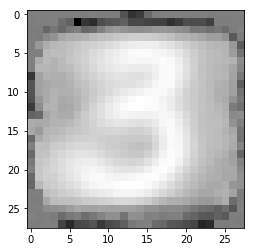

In [137]:
im = images[:,0][9]
im = im.reshape(-1, 28)
plt.imshow(im, cmap='gray')
plt.show()